In [1]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
plt.style.use('dark_background')
%matplotlib inline


In [2]:
np.set_printoptions(precision=2)

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.15.0'

In [5]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.transpose(1, 2, 0)
X_test = X_test.transpose(1, 2, 0)
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
num_labels = len(np.unique(y_train))
num_features = X_train.shape[0]
num_samples = X_train.shape[1]


In [6]:
# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train).T
Y_test = tf.keras.utils.to_categorical(y_test).T


In [7]:
# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)
print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


In [8]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None
  def forward(self, input):
    pass
  def backward(self, output_gradient, learning_rate):
    pass

In [9]:
## Define the loss function and its gradient
def cce(Y, Yhat):
  return(np.mean(np.mean(-Y * np.log(Yhat + 1e-15), axis = 1)))
def cce_gradient(Y, Yhat):
  return - (Y/ (Yhat + 1e-15))
# TensorFlow in-built function for categorical crossentropy loss
#cce = tf.keras.losses.CategoricalCrossentropy()

In [10]:
## Softmax activation layer class
class Softmax(Layer):
  def forward(self, input):
    self.input = input
    self.output = tf.nn.softmax(input, axis = 1).numpy()
  def backward(self, output_gradient, learning_rate = None):
## Following is the inefficient way of calculating the backward gradient
      softmax_gradient = np.empty_like(self.input, dtype=np.float64)
      #softmax_gradient[:, b] = np.dot((np.identity(self.output.shape[0])-self.?[:, ?].T) * self.output[?, ?], ?[:, b])
      for b in range(output_gradient.shape[1]):
          softmax_gradient[:, b] = np.dot(
              (np.identity(self.output.shape[0]) - np.outer(self.output[:, b], self.output[:, b])),
               output_gradient[:, b]
            )
      return(softmax_gradient)
## Following is the efficient of calculating the backward gradient
#T = (np.transpose(np.identity(self.output.shape[0]) - np.atleast_2d(self.output).T[:, np.newaxis, :], (1, 2, 0)) * np.atleast_2d(se
#return(np.einsum('ijk, ik -> jk', T, output_gradient))

In [11]:
## Dense layer class
class Dense(Layer):
  def __init__(self, input_size, output_size):
    self.weights = 0.01*np.random.randn(output_size, input_size + 1) # bias trick
    self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
  def forward(self, input):
    self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
    self.output= np.dot(self.weights, self.input)
  def backward(self, output_gradient, learning_rate):
    dense_gradient = (1 / output_gradient.shape[1]) * np.dot(self.weights.T, output_gradient)
    self.weights = self.weights - learning_rate * np.dot(output_gradient, self.input.T)
  ## Following is the inefficient way of calculating the backward gradient
    #dense_gradient = np.zeros((self.output.shape[0], self.input.shape[1]), dtype = np.float64)
    #for b in range(output_gradient.shape[1]):
      #dense_gradient += np.dot(output_gradient, self.input.T)
    #dense_gradient = (1/output_gradient.shape[1])*dense_gradient
    ## Following is the efficient way of calculating the backward gradient
    #dense_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
    #self.weights = self.weights - learning_rate * (dense_gradient)


In [12]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)


In [13]:
## Example generation of batch indices
batch_size = 100
batch_indices = generate_batch_indices(num_samples, batch_size)
print(batch_indices)


[array([52791, 17949, 38313, 19435, 41536,  6283, 28630, 31316, 11757,
       22422, 26467, 39665, 34886,  7978, 25209, 23156, 45100, 36459,
       55978, 52875, 27138,  5046, 17259, 13513, 11570,  2828, 51480,
        5725,  4436, 19659, 42373, 37628, 41349, 44500, 51490, 28609,
       15942, 50536,  7442, 58879, 14619, 47945, 45446, 53703, 15574,
        3212, 42675, 45047, 11271, 36065, 24352, 42716, 26215, 49144,
        6130, 32452, 53710, 47938, 18537, 10044, 16654, 53025, 39337,
        6068, 39696, 20491, 50282, 15748, 30146,  1137, 57446, 30182,
       16671, 31759, 18290, 54639,  7200, 43776, 16340,  4559, 42695,
       55700, 45822, 32495, 43177, 50497,  7046,  5285, 37548, 14131,
       47854, 49747, 51895, 51006,  9244, 57205, 49282, 47106,  3769,
       10251]), array([59567, 51859, 18442, 24670, 32744, 59574, 57251, 35612, 18380,
       28964, 39533,  5765, 59136, 15505, 30549, 26605, 23793, 54128,
       41214, 27114, 29835, 14492, 22887, 12042, 28981,  5449, 36931,
   

In [14]:
## Train the 0-layer neural network using batch training with batch size = 16
learning_rate = 0.01 # learning rate
batch_size = 16 # batch size
nepochs = 10 # number of epochs
loss_epoch = np.empty(nepochs, dtype = np.float32) # create empty array to store losses over each epoch

# Neural network architecture
dlayer = Dense(num_features, num_labels) # define dense layer
softmax = Softmax() # define softmax activation layer

# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.
epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  for b in range(len(batch_indices)):
    dlayer.forward(X_train[:, batch_indices[b]]) # forward prop
    softmax.forward(dlayer.output) # Softmax activate
    loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate loss
    # Backward prop starts here
    grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer.backward(grad, learning_rate)
  loss_epoch[epoch] = loss/len(batch_indices)
  print('Epoch %d: loss = %f'%(epoch+1, loss_epoch[epoch]))
  epoch = epoch + 1


Epoch 1: loss = 2.763252
Epoch 2: loss = 2.767074
Epoch 3: loss = 2.766613
Epoch 4: loss = 2.767592
Epoch 5: loss = 2.767650
Epoch 6: loss = 2.768571
Epoch 7: loss = 2.766556
Epoch 8: loss = 2.768916
Epoch 9: loss = 2.766959
Epoch 10: loss = 2.771046


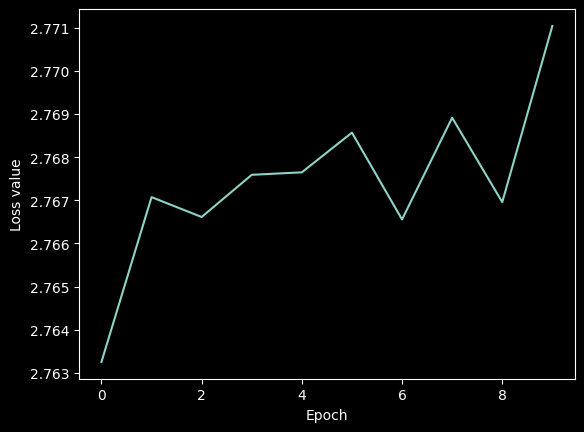

In [15]:
## Plot training loss as a function of epoch:
plt.plot(loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()


In [20]:
## Accuracy on test set
dlayer.forward(X_test)
softmax.forward(dlayer.output)
ypred = np.argmax(softmax.output.T, axis = 1)
print(ypred)
ytrue = np.argmax(Y_test.T, axis = 1)
print(ytrue)
np.mean(ytrue == ypred)


[7 5 1 ... 4 8 6]
[7 2 1 ... 4 5 6]


0.6565